In [2]:
import numpy as np
import pandas as pd
import pydicom as dicom
import matplotlib.pyplot as plt
import cv2
import os

### Open image

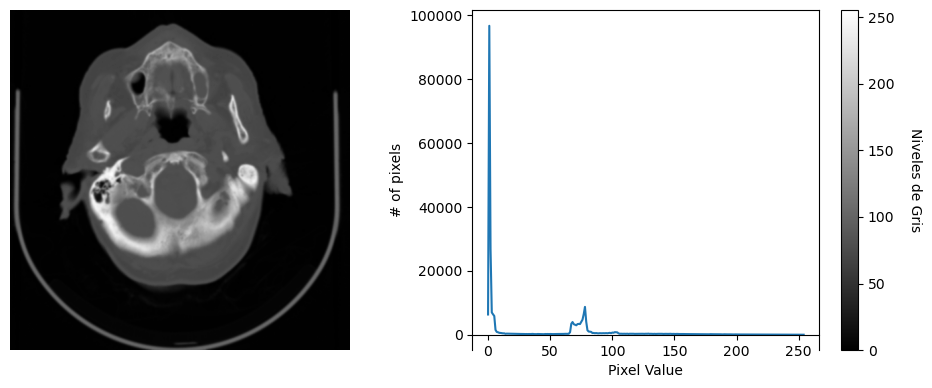

In [3]:
def open_image(path_to_image):
    ds = dicom.dcmread(path_to_image)
    return ds.pixel_array

def im_uint8f(image):
    return (image / np.max(image) * 255).astype(np.uint8)


PATH = os.path.join('C://Users\mario\Python\Projects//regionsegment_biomed\DICOM_image', 'im1.dcm')
pixel_data = open_image(PATH)
im_uint8 = im_uint8f(pixel_data)

def histogram_image(image):
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    #Plot the image
    im = axes[0].imshow(image, cmap='gray')
    axes[0].axis('off')
    bins = np.max(image)
    # Plot the histogram
    hist = cv2.calcHist([image], [0], None, [bins], [0, bins])
    axes[1].plot(hist)
    axes[1].set_xlabel("Pixel Value")
    axes[1].set_ylabel("# of pixels")
    # Move the x-axis to y=0
    axes[1].spines['bottom'].set_position('zero')
    cbar = plt.colorbar(im, ax=axes[1])
    cbar.set_label('Niveles de Gris', rotation=270, labelpad=20)
    plt.tight_layout()
    plt.show()
    return None

histogram_image(im_uint8)

### Cualitative analysis

In [4]:
"""
    This function is designed to visually enhance the areas of interest in a grayscale image by applying a color 
    overlay where a binary mask is active. It operates by first converting the single-channel grayscale image into a 
    three-channel BGR color image using OpenCV's cv2.cvtColor function. Then it locates the active pixels in the 
    mask—typically the ones with a value of 255, indicating the regions of interest. For each active pixel, 
    it substitutes the corresponding pixel in the color image with the specified overlay color (defaulting to red). 
    The result is a color image that retains its original grayscale appearance except in areas corresponding to the 
    mask, where the chosen color now highlights the region of interest.
"""
def overlay_mask_on_image(image, mask, color=(255, 0, 0)):
    """
    Applies a colored mask over the original grayscale image to highlight the regions of interest.

    @:param mask: A binary mask where non-zero (typically 255) indicates the regions of interest.
    @:type: numpy.ndarray
    @:param color: A 3-tuple representing the BGR color (Blue, Green, Red) to overlay where the mask is
    active. Default is red.
    @:type: tuple

    @:return color_image (numpy.ndarray): The original image with the mask overlay in the specified color.
    """
    # Create a 3-channel version of the grayscale image
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Identify where the mask is active
    active_pixels = (mask == 255)

    # Apply color to the active mask regions in the image
    color_image[active_pixels] = color

    return color_image

"""
This function serves as a visualization tool to compare the original grayscale image, the binary mask, 
and the overlay image side by side. It uses Matplotlib to create a figure with three subplots: the first for the 
original image, the second for the mask, and the third for the color overlay on the original image. The grayscale 
image is displayed as is, while the mask is shown with a grayscale colormap to identify the regions of interest 
clearly. Finally, the function creates an overlay image by calling the overlay_mask_on_image method, 
which applies the colored mask to the original image. This overlay is then displayed in the third subplot. The 
titles 'Original Image,' 'Mask,' and 'Overlayed mask on image' are set for each subplot respectively, 
and the axes are turned off for a cleaner presentation. The visualize function concludes by displaying the 
composite figure, which provides a comprehensive view of the segmentation result.
"""
def visualize(image, mask, color=(255, 0, 0)):
    """
    Displays the original image, the mask, and the overlay of the mask on the original image side by side for
    comparison.

    @:param mask: A binary mask where non-zero (typically 255) indicates the regions of interest.
    @:type numpy.ndarray
    @:param color: A 3-tuple representing the BGR color (Blue, Green, Red) to overlay on the mask.
    @:type tuple
    Default is red.
    """
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    overlay = overlay_mask_on_image(image, mask, color=color)
    plt.subplot(1, 3, 3)
    plt.imshow(overlay, cmap='gray')
    plt.title('Overlayed mask on image')
    plt.axis('off')

    plt.show()


### Cuantitative Analysis

#### Descriptors

In [5]:
import skimage
from skimage import feature
from scipy.stats import entropy

def calculate_descriptors(image, mask):
    """
    Calculate image descriptors for the given mask on the image.
    
    Parameters:
    - image (numpy.ndarray): 2D array representing the grayscale image.
    - mask (numpy.ndarray): 2D binary array where 1's represent the segmented region.
    
    Returns:
    - descriptors (dict): Dictionary with descriptors and their values.
    """
    masked_image = image * mask
    descriptors = {}

    # Intensity Descriptors
    descriptors['mean_intensity'] = np.mean(masked_image[mask > 0])
    descriptors['median_intensity'] = np.median(masked_image[mask > 0])
    descriptors['std_intensity'] = np.std(masked_image[mask > 0])
    descriptors['max_intensity'] = np.max(masked_image[mask > 0])
    descriptors['min_intensity'] = np.min(masked_image[mask > 0])

    # Shape Descriptors
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area = cv2.contourArea(contours[0])
    perimeter = cv2.arcLength(contours[0], True)
    descriptors['area'] = area
    descriptors['perimeter'] = perimeter
    descriptors['circularity'] = (4 * np.pi * area) / (perimeter * perimeter) if perimeter != 0 else 0

    # Texture Descriptors
    glcm = skimage.feature.graycomatrix(masked_image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], 256, symmetric=True, normed=True)
    descriptors['contrast'] = skimage.feature.graycoprops(glcm, 'contrast')[0, 0]
    descriptors['correlation'] = skimage.feature.graycoprops(glcm, 'correlation')[0, 0]
    descriptors['energy'] = skimage.feature.graycoprops(glcm, 'energy')[0, 0]
    descriptors['homogeneity'] = skimage.feature.graycoprops(glcm, 'homogeneity')[0, 0]

    # Entropy
    hist, _ = np.histogram(masked_image[mask > 0], bins=256, range=(0, 256))
    hist = hist / hist.sum()  # Normalize the histogram
    descriptors['entropy'] = entropy(hist)

    return descriptors

#### Dice coefficient

In [6]:
def dice_coefficient(mask1, mask2):
    """
    Calculate the Dice Coefficient between two binary masks.
    
    Parameters:
    - mask1 (numpy.ndarray): 2D binary array, where 1's represent the first segmented region.
    - mask2 (numpy.ndarray): 2D binary array, where 1's represent the second segmented region.
    
    Returns:
    - dice_coeff (float): Dice Coefficient as a float between 0.0 and 1.0.
    """
    mask1 = np.where(mask1 == 255, 1, 0)
    mask2 = np.where(mask2 == 255, 1, 0)
    # Calculate intersection and union
    intersection = np.logical_and(mask1, mask2).sum()
    union = mask1.sum() + mask2.sum()

    # Calculate Dice Coefficient
    dice_coeff = 2. * intersection / union if union != 0 else 1.0

    return dice_coeff

### Mathematical morphology 

In [7]:
def improve_mask(mask, operation='open', kernel_size=3, iterations=1):
    """
    Perform morphological operations to improve the properties of a binary mask.

    Parameters:
    - mask (numpy.ndarray): 2D binary mask to be improved.
    - operation (str): Morphological operation to be performed ('open', 'close', 'erode', 'dilate').
    - kernel_size (int): Size of the kernel used for the morphological operation.
    - iterations (int): Number of times the operation is applied.

    Returns:
    - improved_mask (numpy.ndarray): The improved binary mask.
    """

    # Create the kernel for the morphological operation
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Dictionary of available morphological operations
    operations = {
        'open': cv2.MORPH_OPEN,      # Opening (erosion followed by dilation)
        'close': cv2.MORPH_CLOSE,    # Closing (dilation followed by erosion)
        'erode': cv2.MORPH_ERODE,    # Erosion
        'dilate': cv2.MORPH_DILATE,  # Dilation
    }

    if operation not in operations:
        raise ValueError(f"Operation '{operation}' is not supported. Choose from 'open', 'close', 'erode', 'dilate'.")

    # Perform the chosen morphological operation
    improved_mask = cv2.morphologyEx(mask, operations[operation], kernel, iterations=iterations)

    return improved_mask

### Ground truth mask

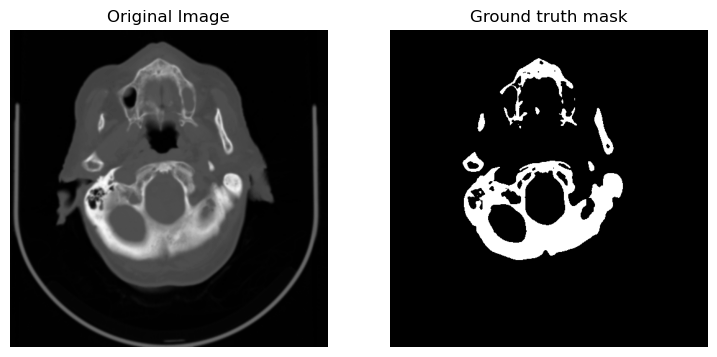

In [8]:
def umbralizacion_manual(img, lower_bound, upper_bound=255):
    # Inicializamos una imagen de ceros con el tamaño de la imagen de entrada
    thresholded_image = np.zeros_like(img)
    # Thresholding manual
    thresholded_image[(img >= lower_bound) & (img <= upper_bound)] = 255  # Setting pixels in the ROI to white
    return thresholded_image

ground_truth = umbralizacion_manual(im_uint8, 110, upper_bound=255)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,9))
axes[0].imshow(im_uint8, cmap='gray')
axes[0].axis('off')
axes[0].set_title("Original Image")
axes[1].imshow(ground_truth, cmap='gray')
axes[1].axis('off')
axes[1].set_title("Ground truth mask")
plt.show()

## Region growing

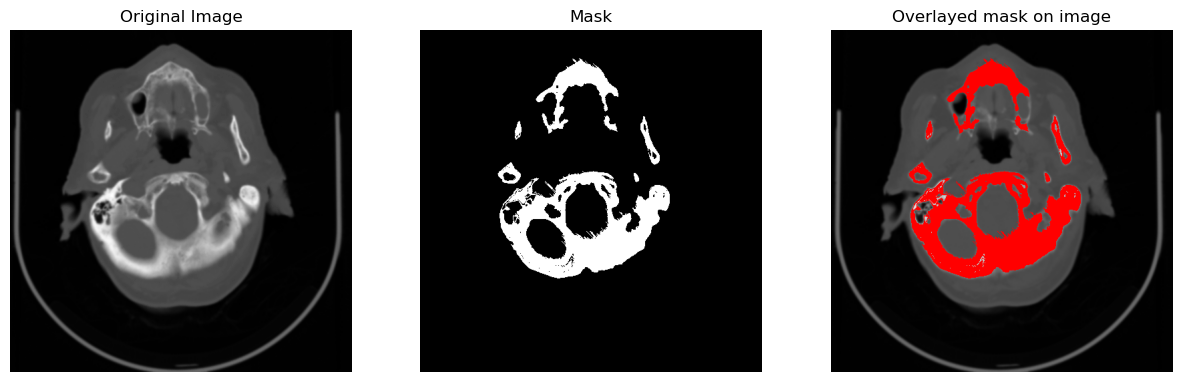

In [9]:
from RegionGrowingClass import RegionGrowingPython

reg_grow = RegionGrowingPython(image=im_uint8,
                               seeds_lth=153,
                               seeds_hth=154,
                               seeds_dist=14)

segmented = reg_grow.region_grow(threshold=153,
                                 std_max_variation=10.9)
segmented = segmented.astype(np.uint8) * 255
visualize(image= im_uint8,
          mask= segmented)

### Improving the result

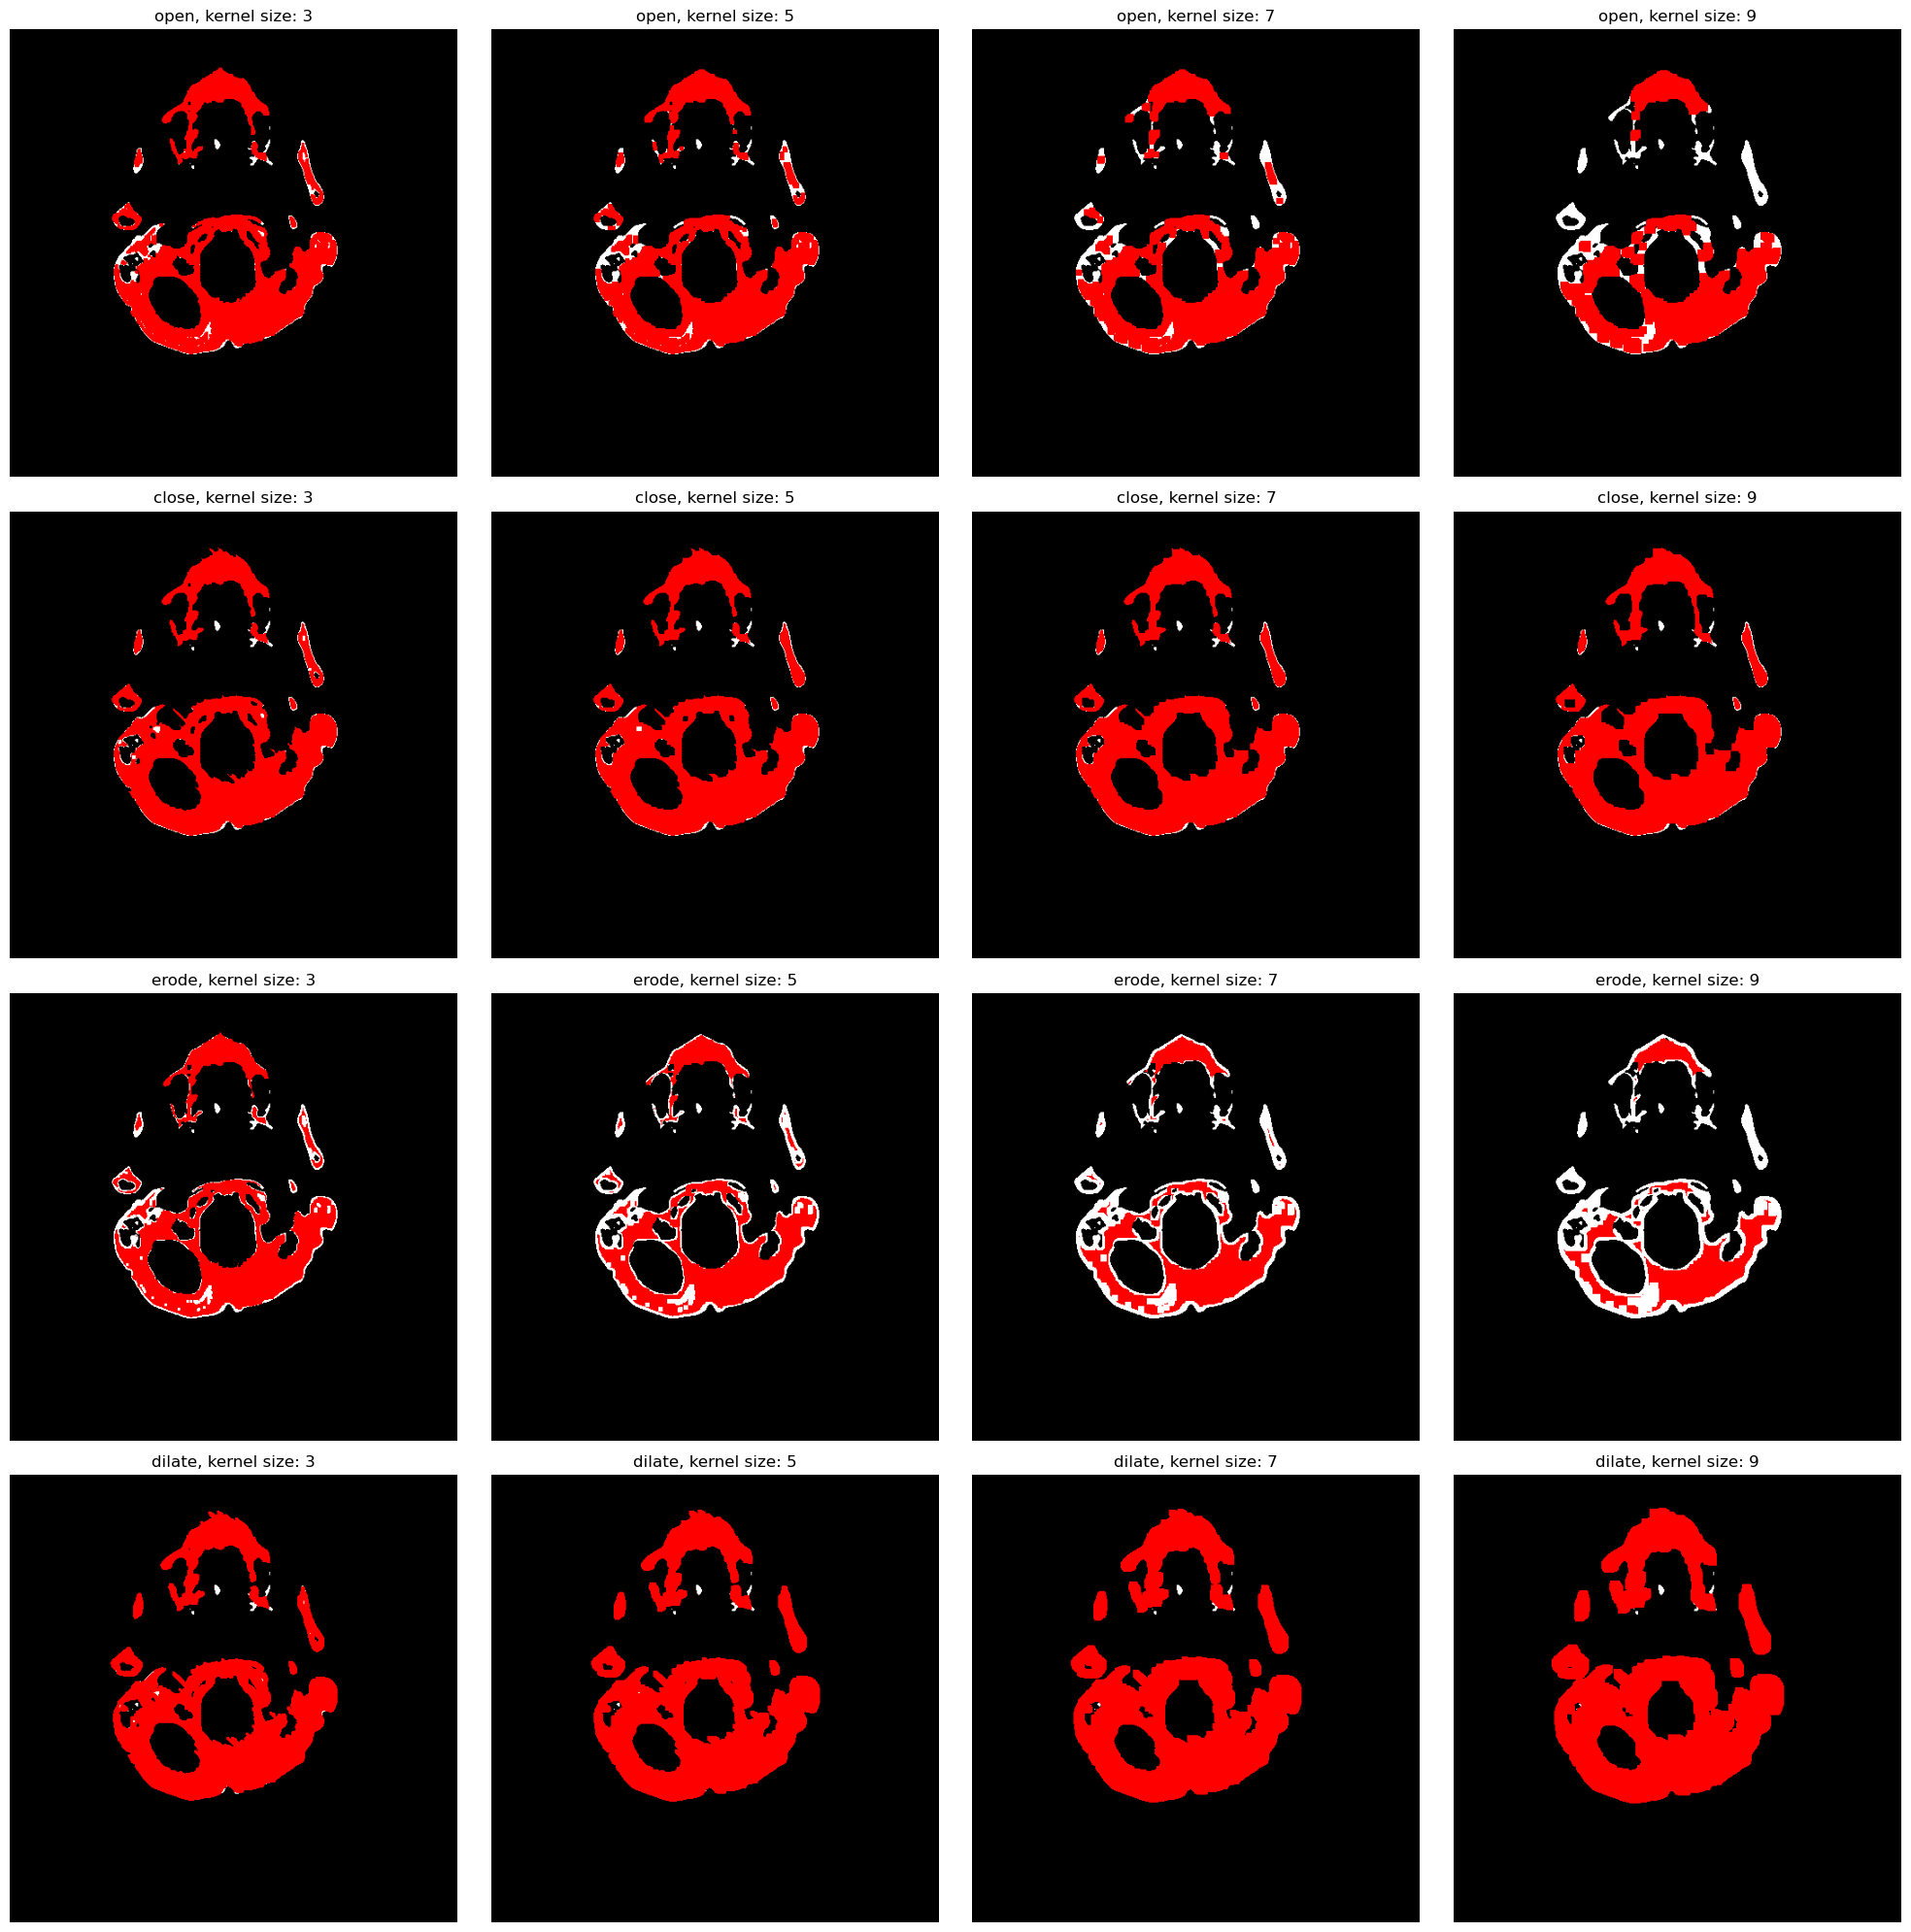

In [10]:
def morphology(mask, operations, kernel_sizes):
    num_operations = len(operations)
    num_kernels = len(kernel_sizes)
    total_plots = num_operations * num_kernels  # Total number of plots
    assert total_plots <= 16, "Total number of subplots should be less than or equal to 16"
    
    results = {op: [] for op in operations}
    plt.figure(figsize=(20, 20))

    # Create a subplot for each combination of operation and kernel size
    subplot_idx = 1  # Initialize subplot index
    for i, operation in enumerate(operations):
        for size in kernel_sizes:
            mask_imp = improve_mask(mask, operation=operation, kernel_size=size)

            ax = plt.subplot(4, 4, subplot_idx)  # Update to use subplot_idx
            ax.imshow(overlay_mask_on_image(ground_truth, mask_imp), cmap='gray')
            ax.set_title(f"{operation}, kernel size: {size}")
            ax.axis('off')
            results[f'{operation}'].append(dice_coefficient(mask_imp, ground_truth))
            subplot_idx += 1  # Move to the next subplot index

    plt.tight_layout()
    plt.show()
    return results
# Example usage with dummy operations and kernel sizes
morf_dice = morphology(segmented, ['open', 'close', 'erode', 'dilate'], [3, 5, 7, 9])


In [11]:
morf_df = pd.DataFrame(data=morf_dice, index=[3, 5, 7, 9])
print(morf_df.to_latex(index=True,
                  float_format="{:4f}".format,
                  ))

\begin{tabular}{lrrrr}
\toprule
 & open & close & erode & dilate \\
\midrule
3 & 0.912678 & 0.914640 & 0.873572 & 0.874773 \\
5 & 0.900102 & 0.908425 & 0.777272 & 0.818895 \\
7 & 0.868560 & 0.903077 & 0.670798 & 0.771264 \\
9 & 0.818055 & 0.894674 & 0.572506 & 0.730702 \\
\bottomrule
\end{tabular}


In [12]:
segmented = improve_mask(segmented, 'close', kernel_size=3)
descriptores_reggrow = pd.DataFrame(data=calculate_descriptors(im_uint8, segmented), index=[0])

print(pd.melt(descriptores_reggrow).to_latex(index=False,
                       float_format="{:4f}".format,
                       ))

\begin{tabular}{lr}
\toprule
variable & value \\
\midrule
mean_intensity & 105.740093 \\
median_intensity & 111.000000 \\
std_intensity & 36.640562 \\
max_intensity & 195.000000 \\
min_intensity & 1.000000 \\
area & 59.000000 \\
perimeter & 34.142135 \\
circularity & 0.636034 \\
contrast & 167.132591 \\
correlation & 0.921140 \\
energy & 0.903871 \\
homogeneity & 0.921102 \\
entropy & 4.957051 \\
\bottomrule
\end{tabular}


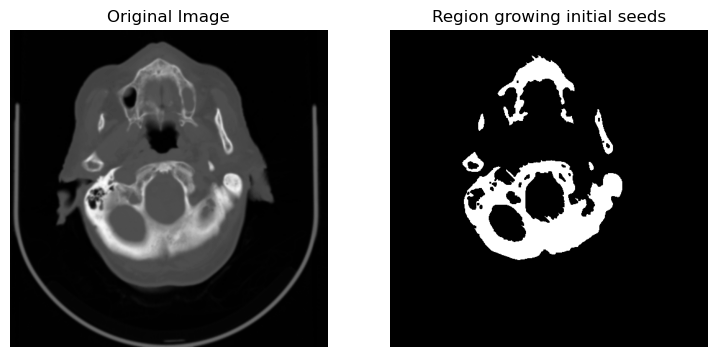

In [13]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,10))
axes[0].imshow(im_uint8, cmap='gray')
axes[0].axis('off')
axes[0].set_title("Original Image")
axes[1].imshow(segmented, cmap='gray')
axes[1].axis('off')
axes[1].set_title("Region growing initial seeds")
plt.show()

## Split and Merge

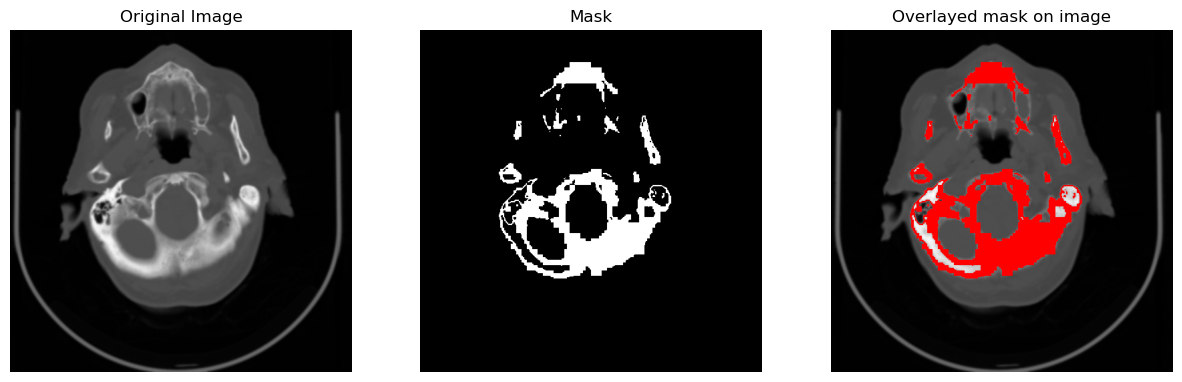

In [14]:
from SplitAndMerge import SplitAndMerge

spmg = SplitAndMerge(image=im_uint8, 
                     min_th=106,
                     max_th=255,
                     min_dim=1)
mask_spmg = SplitAndMerge.split_and_merge(spmg).astype(np.uint8)

mask_spmg[mask_spmg > 0] = 255

visualize(image=im_uint8,
          mask=mask_spmg)

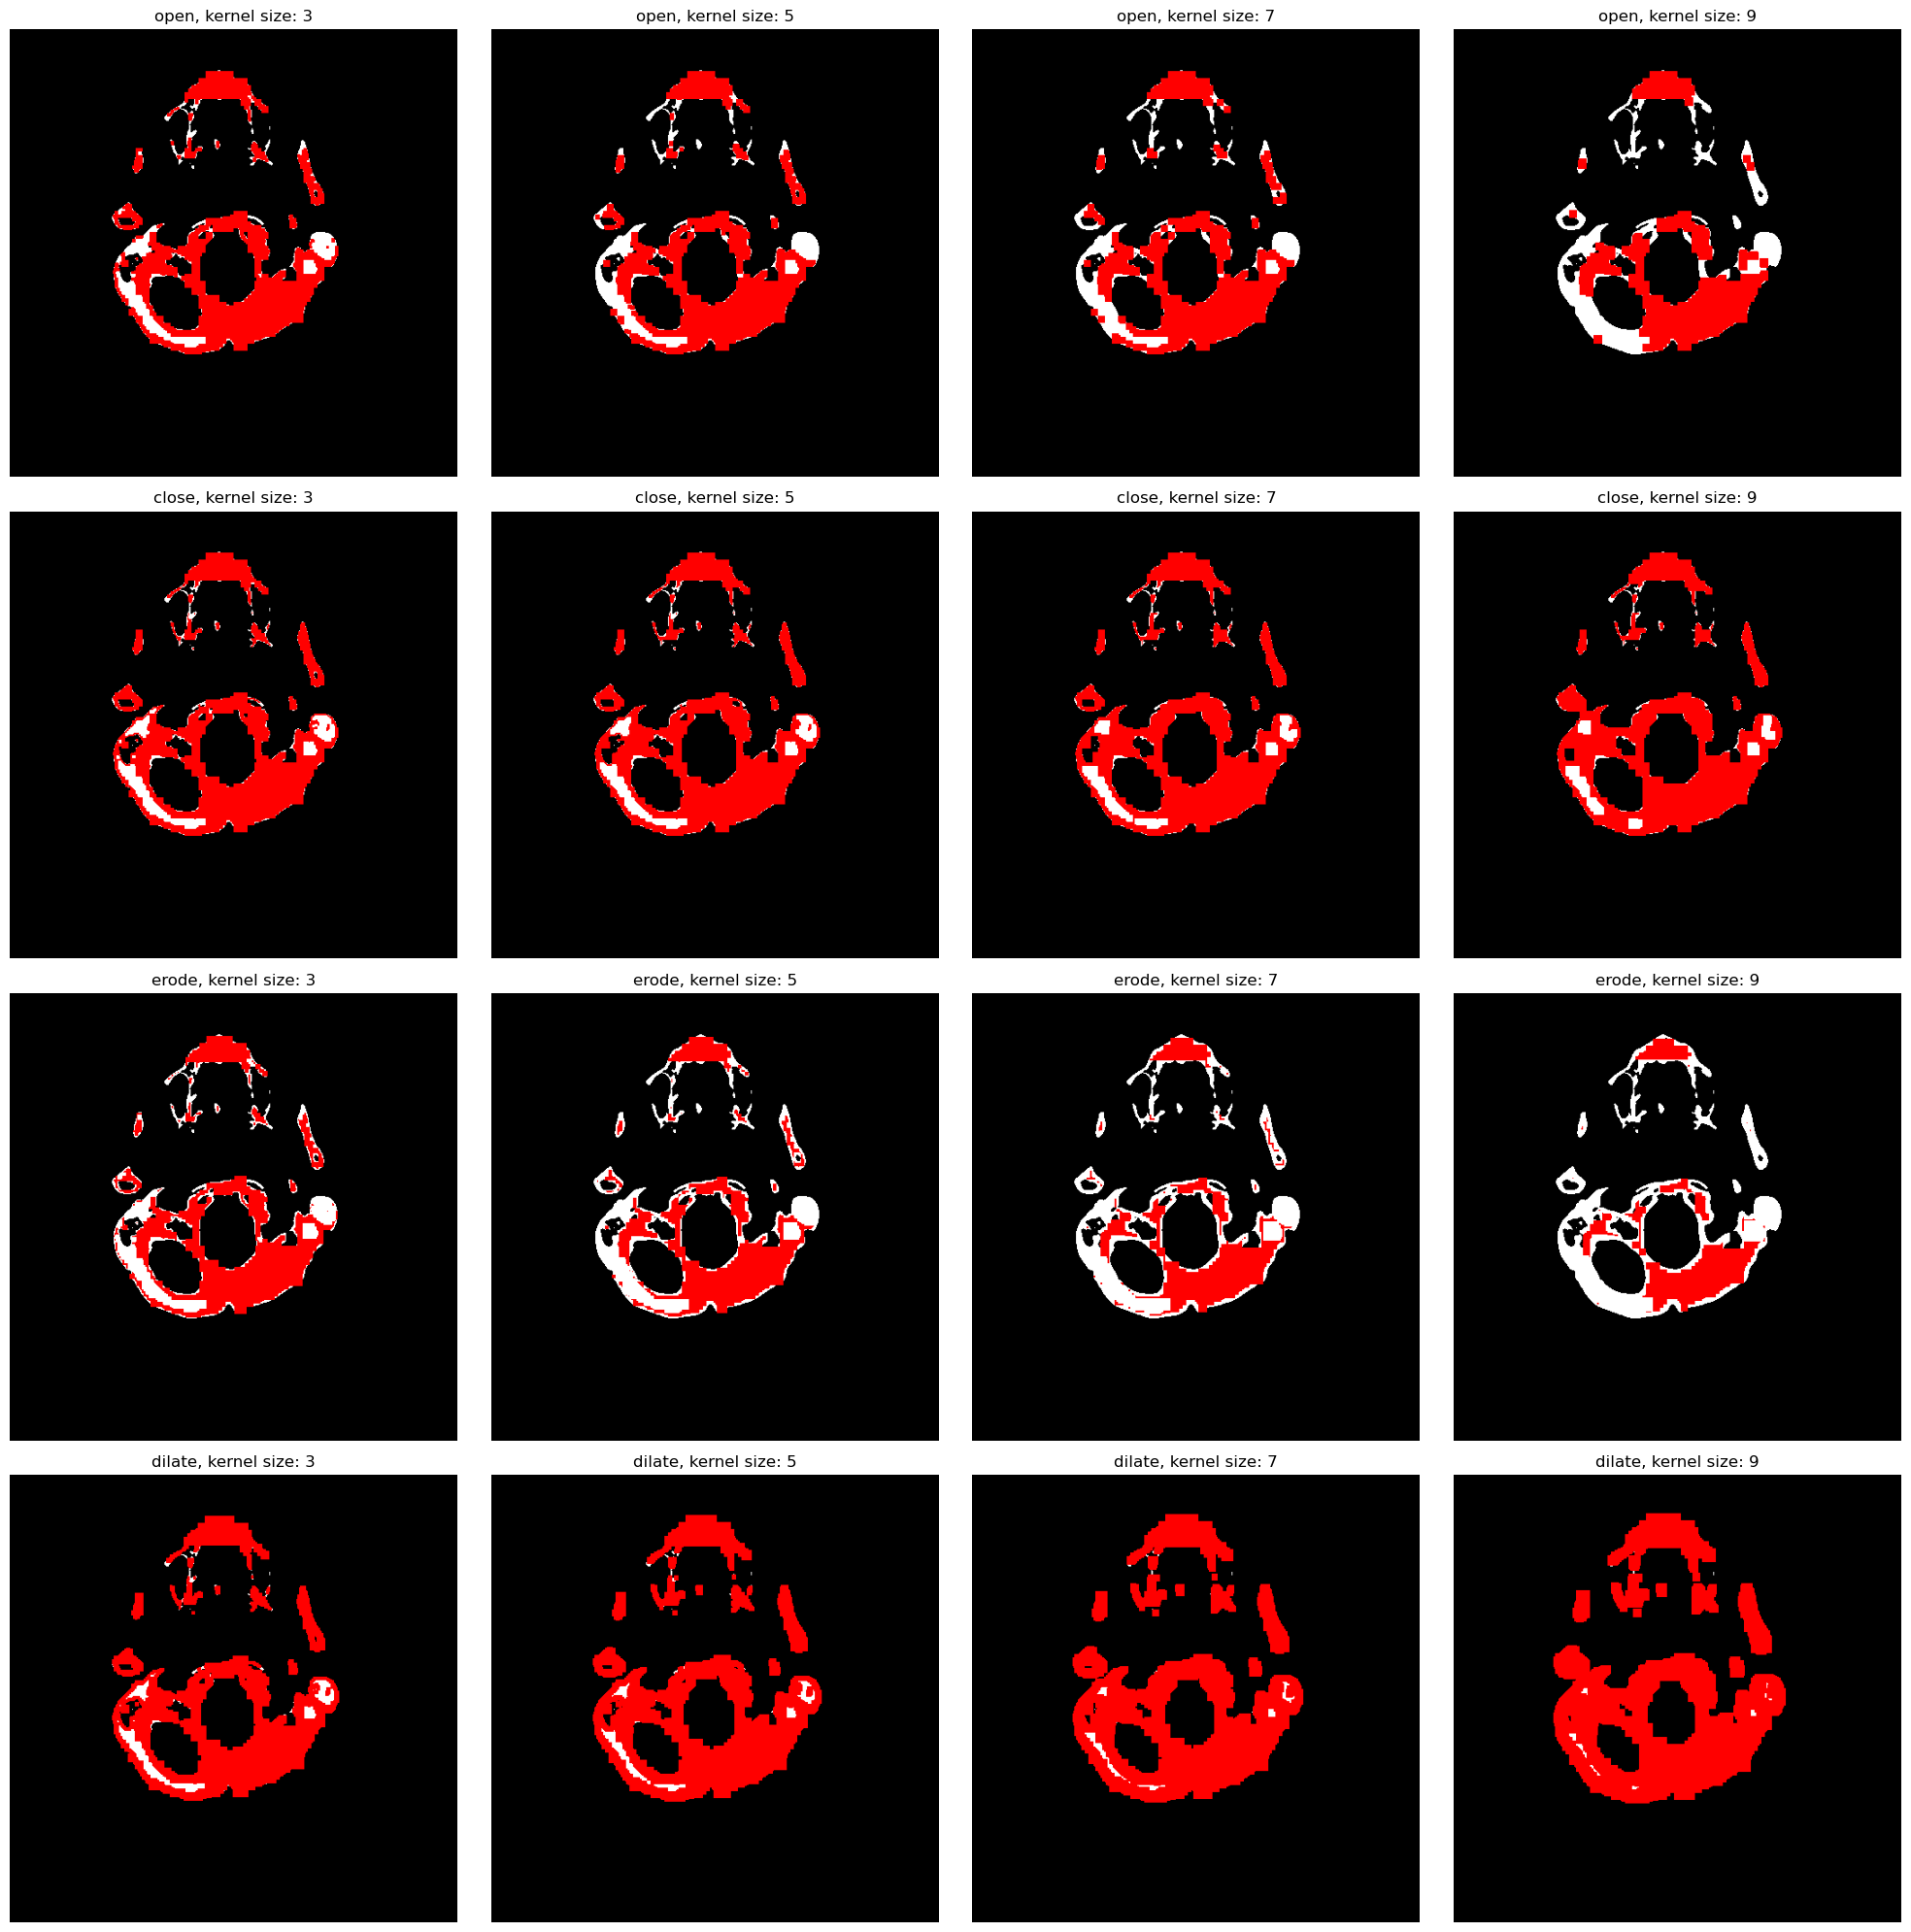

\begin{tabular}{lrrrr}
\toprule
 & open & close & erode & dilate \\
\midrule
3 & 0.836599 & 0.855851 & 0.778046 & 0.847026 \\
5 & 0.806391 & 0.858782 & 0.686027 & 0.810338 \\
7 & 0.783926 & 0.861839 & 0.596428 & 0.774666 \\
9 & 0.704826 & 0.863420 & 0.507711 & 0.740602 \\
\bottomrule
\end{tabular}


In [15]:
morf_dice_spam = morphology(mask_spmg, ['open', 'close', 'erode', 'dilate'], [3, 5, 7, 9])
morf_df_spam = pd.DataFrame(data=morf_dice_spam, index=[3, 5, 7, 9])
print(morf_df_spam.to_latex(index=True,
                       float_format="{:4f}".format,
                       ))

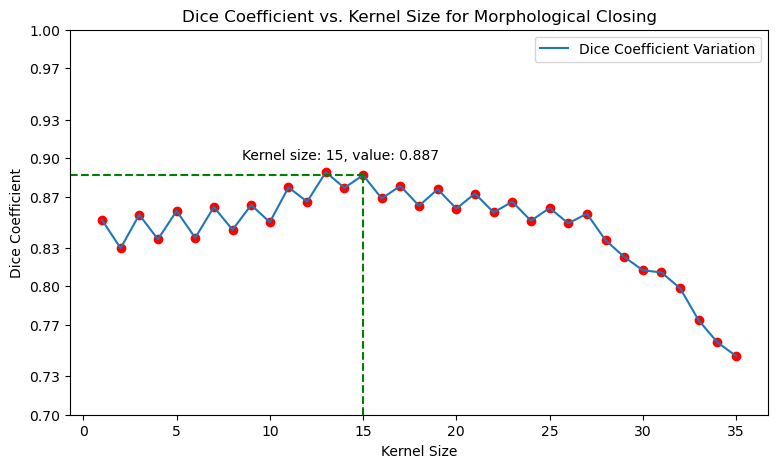

In [73]:
close_vals = np.linspace(1, 35, num=35).astype(np.int8)
dice_coefs = {}

for val in close_vals:
    this_mask = improve_mask(mask_spmg, 
                             operation="close",
                             kernel_size=val)
    dice_coefs[val] = dice_coefficient(this_mask, ground_truth)

plt.figure(figsize=(9,5))
plt.plot(dice_coefs.keys(), dice_coefs.values(), label="Dice Coefficient Variation")
plt.scatter(x=dice_coefs.keys(), y=dice_coefs.values(), marker="o", c='red')
max_key = max(dice_coefs, key=lambda k: dice_coefs[k].round(3))
plt.annotate(text=f"Kernel size: {max_key}, value: {dice_coefs[max_key]:.3f}", xy=(max_key, dice_coefs[max_key]),
             xytext=(max_key-4.5, dice_coefs[max_key]+.01))
plt.axvline(x=max_key, ymax=dice_coefs[max_key]/1.42, color='green', linestyle='--')
plt.axhline(y=dice_coefs[max_key], xmax=max_key/35.3, color='green', linestyle='--')
plt.xlabel("Kernel Size")
plt.ylabel("Dice Coefficient")
plt.yticks(np.linspace(.7, 1, num=10).round(2))
plt.title("Dice Coefficient vs. Kernel Size for Morphological Closing")
plt.legend()
plt.show()

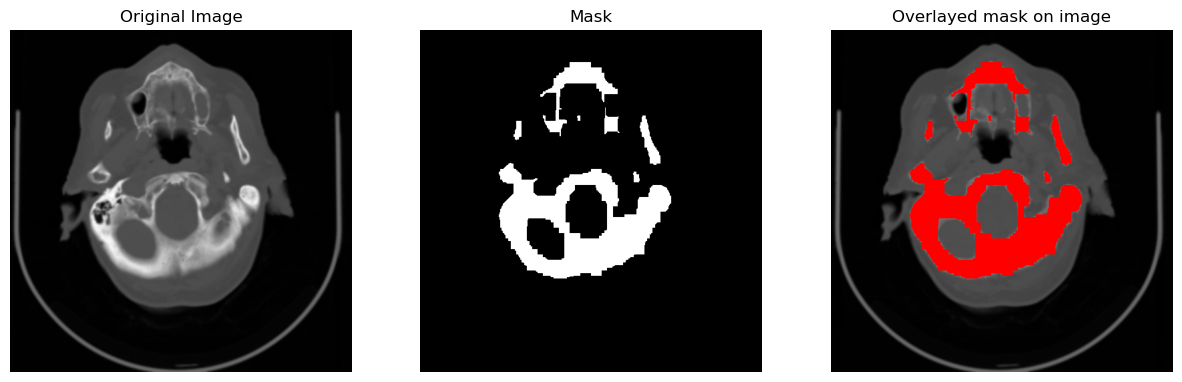

\begin{tabular}{lr}
\toprule
variable & value \\
\midrule
mean_intensity & 110.659401 \\
median_intensity & 114.000000 \\
std_intensity & 39.847590 \\
max_intensity & 245.000000 \\
min_intensity & 1.000000 \\
area & 96.500000 \\
perimeter & 45.071068 \\
circularity & 0.596955 \\
contrast & 129.104987 \\
correlation & 0.949102 \\
energy & 0.896551 \\
homogeneity & 0.915494 \\
entropy & 5.057749 \\
\bottomrule
\end{tabular}


In [75]:
mask_spmg = improve_mask(mask_spmg, operation='close', kernel_size=15)
visualize(im_uint8, mask_spmg)
descriptores_spam = pd.DataFrame(data=calculate_descriptors(im_uint8, mask_spmg), index=[0])

print(pd.melt(descriptores_spam).to_latex(index=False,
                                             float_format="{:4f}".format,
                                             ))

## Analysis

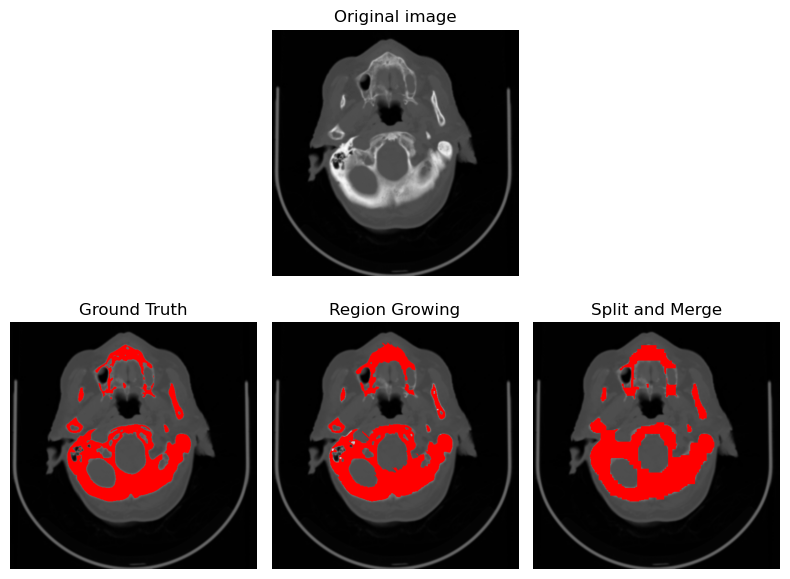

In [108]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6))

axes[0, 1].imshow(im_uint8, cmap='gray')
axes[0, 1].axis('off')
axes[0, 1].set_title("Original image")
axes[0, 0].axis('off')
axes[0, 2].axis('off')

axes[1, 0].imshow(overlay_mask_on_image(im_uint8, ground_truth))
axes[1, 0].axis('off')
axes[1, 0].set_title('Ground Truth')

axes[1, 1].imshow(overlay_mask_on_image(im_uint8, segmented))
axes[1, 1].axis('off')
axes[1, 1].set_title('Region Growing')

axes[1, 2].imshow(overlay_mask_on_image(im_uint8, mask_spmg))
axes[1, 2].axis('off')
axes[1, 2].set_title('Split and Merge')

plt.tight_layout()
plt.show()

In [115]:
final = pd.concat([descriptores_reggrow, descriptores_spam, pd.DataFrame(calculate_descriptors(im_uint8, ground_truth), index=[0])], ignore_index=True)
final['Algorithm'] = ['Region Grow', 'Split and Merge', 'Ground Truth']

# Tu DataFrame original 'final'
# Asegúrate de que 'final' tiene las columnas como en el ejemplo proporcionado

# 'Melt' cambia el DataFrame de un formato ancho a uno largo donde los descriptores son ahora los valores
long_format = final.melt(id_vars='Algorithm', var_name='Descriptor', value_name='Value')

# Pivotea el DataFrame para tener un formato con una columna para cada algoritmo
pivoted_df = long_format.pivot(index='Descriptor', columns='Algorithm', values='Value').reset_index()

# Renombra las columnas para coincidir con lo que deseas
pivoted_df.columns.name = None  # Elimina el nombre de índice de columnas
pivoted_df = pivoted_df.rename(columns={'Region Grow': 'Region_Grow', 'Split and Merge': 'Split_and_Merge', 'Ground Truth': 'Ground_Truth'})

print(pivoted_df.to_latex(index=False,
                                          float_format="{:4f}".format,
                                          ))

\begin{tabular}{lrrr}
\toprule
Descriptor & Ground_Truth & Region_Grow & Split_and_Merge \\
\midrule
area & 92.000000 & 59.000000 & 96.500000 \\
circularity & 0.688738 & 0.636034 & 0.596955 \\
contrast & 172.833445 & 167.132591 & 129.104987 \\
correlation & 0.900620 & 0.921140 & 0.949102 \\
energy & 0.910859 & 0.903871 & 0.896551 \\
entropy & 4.750314 & 4.957051 & 5.057749 \\
homogeneity & 0.926376 & 0.921102 & 0.915494 \\
max_intensity & 146.000000 & 195.000000 & 245.000000 \\
mean_intensity & 99.914224 & 105.740093 & 110.659401 \\
median_intensity & 106.000000 & 111.000000 & 114.000000 \\
min_intensity & 1.000000 & 1.000000 & 1.000000 \\
perimeter & 40.970562 & 34.142135 & 45.071068 \\
std_intensity & 33.292425 & 36.640562 & 39.847590 \\
\bottomrule
\end{tabular}


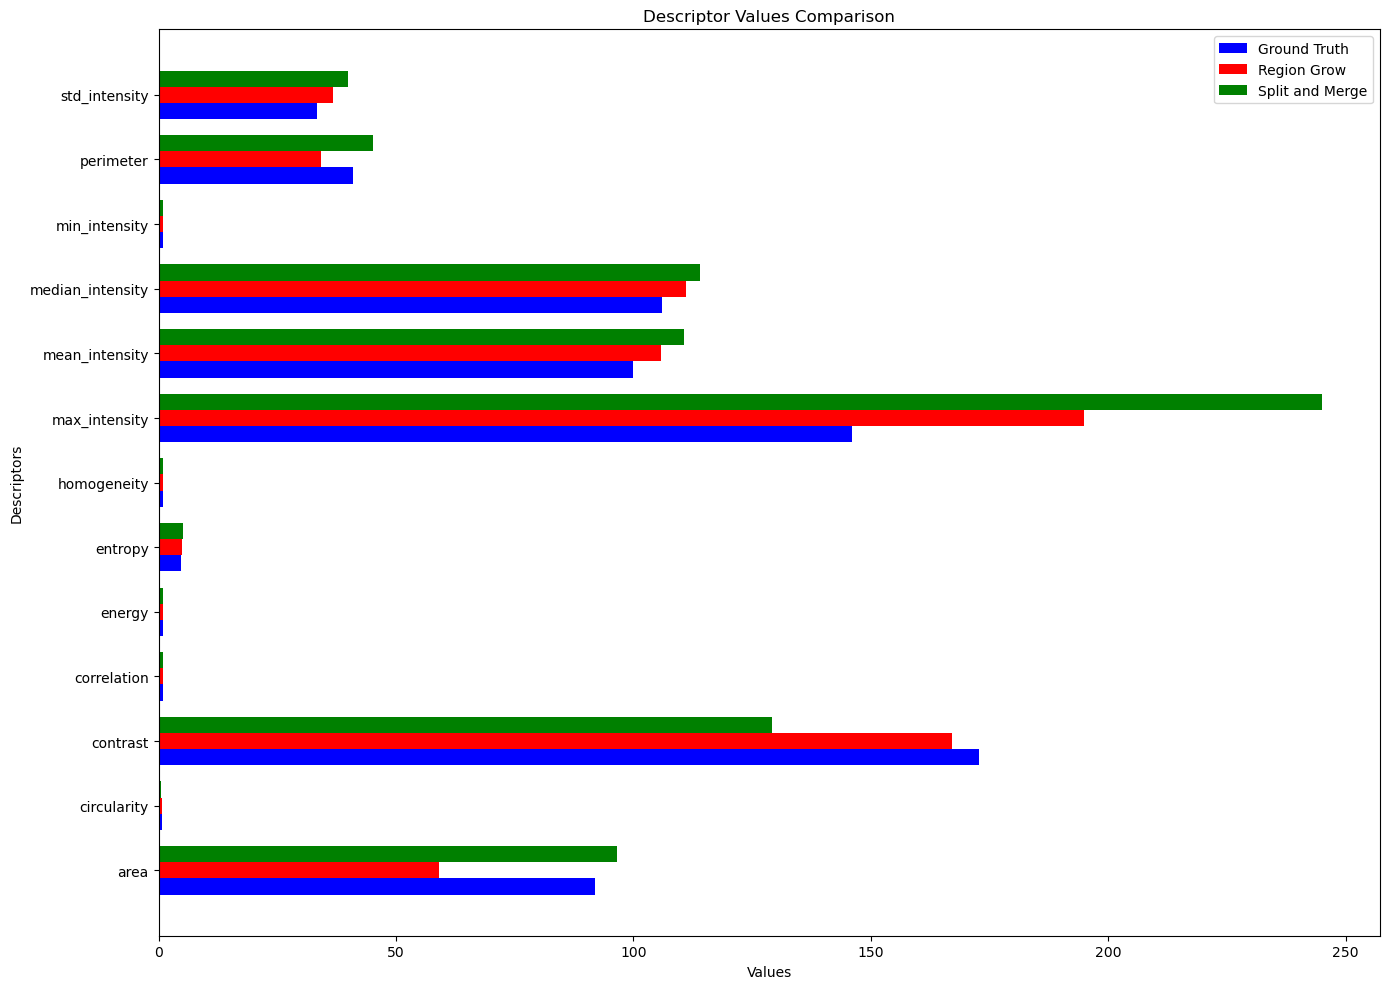

In [114]:
df = pivoted_df.copy()
# Configuramos el tamaño del gráfico
plt.figure(figsize=(14, 10))

# Número de descriptores
n_descriptors = len(df)

# Índices para cada grupo de barras
index = np.arange(n_descriptors)

# Ancho de cada barra
bar_width = 0.25

# Creación de las barras horizontales para los valores de Ground Truth
plt.barh(index, df['Ground_Truth'], bar_width, label='Ground Truth', color='blue')

# Creación de las barras horizontales para los valores de Region Grow
plt.barh(index + bar_width, df['Region_Grow'], bar_width, label='Region Grow', color='red')

# Creación de las barras horizontales para los valores de Split and Merge
plt.barh(index + bar_width * 2, df['Split_and_Merge'], bar_width, label='Split and Merge', color='green')

# Añadir los nombres de los descriptores en el eje Y
plt.ylabel('Descriptors')
plt.xlabel('Values')
plt.title('Descriptor Values Comparison')
plt.yticks(index + bar_width, df['Descriptor'])
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [131]:
# Calcular las diferencias absolutas
df['Diff_RG'] = abs(df['Ground_Truth'] - df['Region_Grow'])
df['Diff_SM'] = abs(df['Ground_Truth'] - df['Split_and_Merge'])

# Calcular el MSE para cada algoritmo
mse_rg = (df['Diff_RG']**2).mean()
mse_sm = (df['Diff_SM']**2).mean()

print(df.loc[:, ['Descriptor', 'Diff_RG', 'Diff_SM']].to_latex(index=False,
                          float_format="{:4f}".format,
                          ))
# Mostrar los resultados
print(f"Mean Squared Error (Region Grow): {mse_rg}")
print(f"Mean Squared Error (Split and Merge): {mse_sm}")


\begin{tabular}{lrr}
\toprule
Descriptor & Diff_RG & Diff_SM \\
\midrule
area & 33.000000 & 4.500000 \\
circularity & 0.052703 & 0.091783 \\
contrast & 5.700855 & 43.728458 \\
correlation & 0.020520 & 0.048481 \\
energy & 0.006988 & 0.014307 \\
entropy & 0.206737 & 0.307435 \\
homogeneity & 0.005275 & 0.010882 \\
max_intensity & 49.000000 & 99.000000 \\
mean_intensity & 5.825869 & 10.745177 \\
median_intensity & 5.000000 & 8.000000 \\
min_intensity & 0.000000 & 0.000000 \\
perimeter & 6.828427 & 4.100505 \\
std_intensity & 3.348136 & 6.555164 \\
\bottomrule
\end{tabular}

Mean Squared Error (Region Grow): 279.9479954958011
Mean Squared Error (Split and Merge): 920.9828328044234
